# **Step 3: Multi-Label CEFR Text Classification**

Step 3 of this project  will use a Nultiinomial Naive Bayes Classifier to predict the CEFR level of each text from the test data.

In [ ]:
#intsalling packages needed for project
!pip install scikit-learn
!pip install datasets

In [ ]:
#importing packages needed for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
nltk.download('stopwords') # stopwords to remove
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from datasets import load_dataset, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB # for multi label NB classification
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV # for hyperparameter tuning
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import RocCurveDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#loading the training and test data using dataset
raw_datasets = load_dataset("csv", data_files= {"train": "Training Data - EN - Sheet1.csv", "test": "Test Data - EN - Sheet1.csv" })

In [ ]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1728
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 101
    })
})


In [ ]:
raw_datasets.keys()

dict_keys(['train', 'test'])

In [ ]:
#Splitting dataset into train and test and into pandas dataframes to make it easier to preprocess
train_dataset = pd.DataFrame(raw_datasets['train'])
test_dataset = pd.DataFrame(raw_datasets['test'])

## Exploratory Data Analysis

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1728 non-null   object
 1   label   1728 non-null   object
dtypes: object(2)
memory usage: 27.1+ KB


In [ ]:
train_dataset.head()

,text,label
0,You need to try harder in school!\nI am doing ...,A1
1,He dropped his toothbrush. It fell on the floo...,A1
2,"I would like to see my counselor now.\nSorry, ...",A1
3,Jeff sat down. He was in class. He was at scho...,A1
4,He played the piano. He played it very well. H...,A1


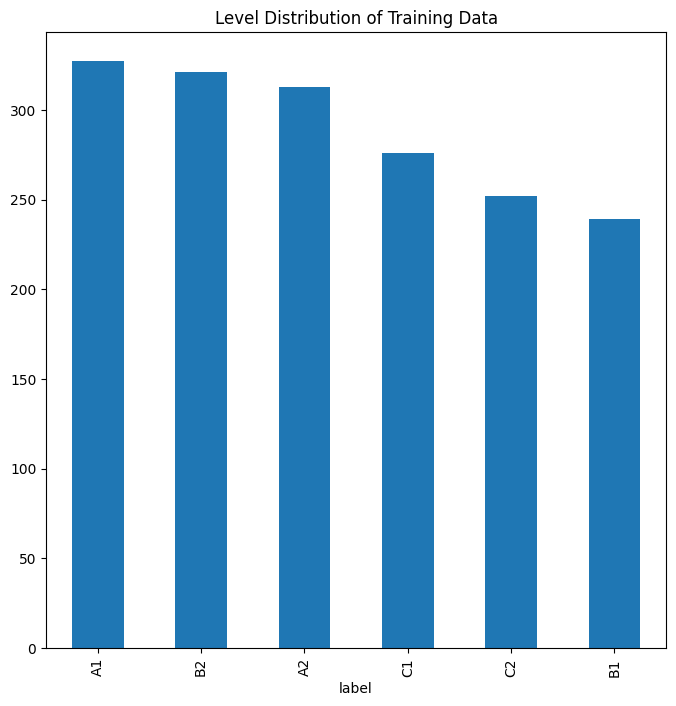

In [ ]:
#number of training instances per level
level_distribution = train_dataset['label'].value_counts()
#Visualising
level_distribution.plot(kind='bar', figsize=(8, 8))
plt.title('Level Distribution of Training Data')
plt.ylabel('')
plt.show()

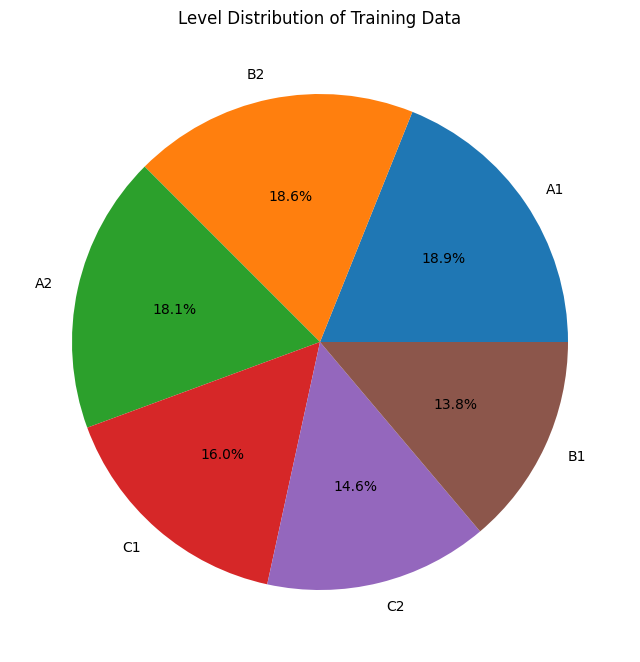

In [ ]:
#pie plot of level distribution
level_distribution = train_dataset['label'].value_counts()
#Visualising
level_distribution.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 18))
plt.title('Level Distribution of Training Data')
plt.ylabel('')
plt.show()

In [ ]:
test_dataset.head()

,text,label
0,Hi Aziz! Are you there?\nHello? Hello?!?\n\nHi...,A1
1,First name: Samia\nLast name: Khan\nDate of bi...,A1
2,Mario called.\nHe wants you to call back befor...,A1
3,Do you like cars? Are you friendly and do you ...,A1
4,City flat\nBeautiful two-bedroom city flat fiv...,A1


In [ ]:
print(len(train_dataset['label']))
print(len(test_dataset['label']))

1728
101


In [ ]:
#checking for consistency
print(train_dataset['label'].unique())
print(test_dataset['label'].unique())

['A1' 'A2' 'B1' 'B2' 'C1' 'C2']
['A1' 'A2' 'B1' 'B2' 'C1' 'C2']


In [ ]:
#mapping CEFR Level labels to integers
train_dataset['label'] = train_dataset['label'].map({'A1':0, 'A2':1, 'B1':2, 'B2':3, 'C1':4, 'C2':5})
test_dataset['label'] = test_dataset['label'].map({'A1':0, 'A2':1, 'B1':2, 'B2':3, 'C1':4, 'C2':5,})

In [ ]:
#checking mapping
train_dataset.head()
test_dataset.head()

,text,label
0,Hi Aziz! Are you there?\nHello? Hello?!?\n\nHi...,0
1,First name: Samia\nLast name: Khan\nDate of bi...,0
2,Mario called.\nHe wants you to call back befor...,0
3,Do you like cars? Are you friendly and do you ...,0
4,City flat\nBeautiful two-bedroom city flat fiv...,0


In [ ]:
train_dataset.tail()

,text,label
1723,"In the heart of the quaint town of Greenbow, A...",5
1724,"As the whistle blew, signaling the end of the ...",5
1725,"In less than a week, Turkey will hold its firs...",5
1726,"In the heart of a bustling metropolis, where t...",5
1727,"When an industry veteran like Larry Pizzi, who...",5


## Naive Bayes Classification

As this is not a binary classification, we will be using 'Multinomial Bayes' for classification.
We will try two methods for processing the data to see how it affects the accuracy of the prediction.

*  Method 1: processing data: only lowercasing the text.
*  Method 2: stemming words and removing stopwords.

The model will be tuned using a RandomizedSearchCV to check for the best hyperparameters.

Further Resources:

[MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

[RandomizedSearchCV](https://sklearner.com/scikit-learn-random-search-multinomialnb/)

#### Method 1

Only preprocessing is lowercasing text

In [ ]:
def preprocess(text):
  text= text.lower()
  return text

In [ ]:
train_data = []
train_data_labels = []
for item in raw_datasets['train']:
  preprocessed_data = preprocess(item['text'])
  train_data.append(preprocessed_data)
  train_data_labels.append(item['label'])
print(train_data[-1])
print(train_data_labels[-1])

when an industry veteran like larry pizzi, who had spent decades in the bicycle industry, first encountered electric bikes in the mid-2000s, he was intrigued by their potential. however, he was skeptical about whether they would catch on with consumers. after all, traditional bicycles had been around for over a century and were still the preferred choice for most people.

but pizzi's skepticism eventually gave way to enthusiasm as he saw the growing demand for electric bikes firsthand. in 2010, he founded pedego electric bikes, one of the first companies to focus exclusively on electric bikes. he believed that electric bikes could revolutionize transportation, providing a cleaner, more efficient, and more enjoyable way to get around.

pizzi's gamble paid off. pedego electric bikes quickly became one of the leading brands in the electric bike industry, and pizzi himself became a leading advocate for electric bikes. he spoke at conferences, wrote articles, and even appeared on television

In [ ]:
#Creating a bag of words
vectorizer = CountVectorizer(analyzer='word',max_features=1000,lowercase=True)
features = vectorizer.fit_transform(train_data).toarray()

In [ ]:
print(features.shape)
print(vectorizer.get_feature_names_out())

(1728, 1000)
['000' '10' '100' '11' '12' '14' '15' '16' '17' '18' '20' '2008' '2009'
 '2011' '2012' '2013' '2014' '24' '25' '30' '40' '50' '500' 'ability'
 'able' 'about' 'above' 'access' 'according' 'account' 'across' 'act'
 'action' 'actually' 'added' 'administration' 'africa' 'after' 'again'
 'against' 'age' 'agency' 'ago' 'agreed' 'ahead' 'air' 'al' 'all' 'almost'
 'alone' 'along' 'already' 'also' 'although' 'always' 'am' 'america'
 'american' 'americans' 'among' 'an' 'and' 'angeles' 'animals' 'announced'
 'another' 'anthony' 'any' 'anyone' 'anything' 'apartment' 'apple' 'are'
 'area' 'areas' 'argument' 'around' 'arrived' 'art' 'as' 'ask' 'asked'
 'at' 'attack' 'attacks' 'attention' 'authorities' 'average' 'away' 'baby'
 'back' 'bad' 'ball' 'bank' 'baseball' 'based' 'basic' 'be' 'beautiful'
 'became' 'because' 'become' 'bed' 'been' 'before' 'began' 'behind'
 'being' 'believe' 'benefits' 'best' 'better' 'between' 'beyond' 'big'
 'biggest' 'bikes' 'bill' 'billion' 'bit' 'black' 'boar

In [ ]:
#creating training and validation splits, used to tune the model
train_data_labels = train_dataset['label']
X_train, X_val, y_train, y_val = train_test_split(features,train_data_labels,train_size=0.9, random_state=1)



In [ ]:
#test data - processed separately
test_data = []
test_data_labels = []
for item in raw_datasets['test']:
  preprocessed_data = preprocess(item['text'])
  test_data.append(preprocessed_data)
  test_data_labels.append(item['label'])

In [ ]:
#Creating a bag of words for test data
test_features = vectorizer.fit_transform(test_data).toarray() # X_test
y_test = test_dataset['label']

In [ ]:
print(test_features.shape)

(101, 1000)
['00' '000' '10' '11' '12' '14' '15' '17' '18' '19' '20' '25' '30' '50'
 'ability' 'able' 'about' 'above' 'accidents' 'according' 'across'
 'active' 'activities' 'actually' 'address' 'adventure' 'advice' 'after'
 'afternoon' 'again' 'against' 'age' 'ago' 'ahead' 'air' 'alice' 'all'
 'almost' 'alone' 'along' 'already' 'also' 'although' 'always' 'am'
 'amazing' 'amount' 'an' 'and' 'another' 'answers' 'any' 'anyone'
 'anything' 'anyway' 'architects' 'architecture' 'are' 'area' 'areas'
 'aren' 'around' 'art' 'arts' 'as' 'asia' 'ask' 'asked' 'asking'
 'asteroid' 'asteroids' 'at' 'attention' 'audience' 'available' 'average'
 'away' 'back' 'bad' 'bags' 'ballet' 'banana' 'base' 'based' 'basis' 'be'
 'beach' 'beautiful' 'beauty' 'became' 'because' 'become' 'been' 'before'
 'began' 'beginning' 'behind' 'being' 'believe' 'best' 'better' 'between'
 'beyond' 'big' 'billion' 'bit' 'black' 'blog' 'boat' 'body' 'book'
 'books' 'born' 'both' 'bottles' 'botton' 'boy' 'brain' 'brains' 'bridge

In [ ]:
#loading model for classification
model = MultinomialNB()
#fitting the model to the training data
model = model.fit(X=X_train,y=y_train)
#testing on the validation data
y_pred = model.predict(X_val)
#accuracy score
print(accuracy_score(y_val,y_pred))

0.5549132947976878



**Accuracy of Method 1:**
0.5549132947976878

## Method 2

Preprocessing: lowercasing, stemming words and removing stopwords

In [ ]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
  text= text.lower()
  text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
  return text

In [ ]:
train_data = []
train_data_labels = []
for item in raw_datasets['train']:
  preprocessed_data = preprocess(item['text'])
  train_data.append(preprocessed_data)
  train_data_labels.append(item['label'])
print(train_data[-1])
print(train_data_labels[-1])

industry vet lik larry pizzi, spent decad bicyc industry, first encount elect bik mid-2000s, intrigu potential. however, skept wheth would catch consumers. all, tradit bicyc around century stil prefer cho people. pizzi's skept ev gav way enthusiasm saw grow demand elect bik firsthand. 2010, found pedego elect bikes, on first company foc exclud elect bikes. believ elect bik could revolv transportation, provid cleaner, efficient, enjoy way get around. pizzi's gambl paid off. pedego elect bik quick becam on lead brand elect bik industry, pizz becam lead advoc elect bikes. spok conferences, wrot articles, ev appear televid promot benefit elect bikes. elect bik industry continu grow, pizz fac new challenges. on challeng high cost elect bikes. ear days, elect bik typ retail $1,000, mak unafford many people. pizz work reduc cost elect bik develop new, efficy technologies. also work retail off fin opt mak elect bik affordable. anoth challeng lack infrastruct elect bikes. many city town bik lan

In [ ]:
#Creating a bag of words
vectorizer = CountVectorizer(analyzer='word',max_features=1000,lowercase=True)
features = vectorizer.fit_transform(train_data).toarray()

In [ ]:
print(features.shape)
print(vectorizer.get_feature_names_out())

(1728, 1000)
['000' '10' '100' '11' '12' '14' '15' '16' '17' '18' '20' '2009' '2011'
 '2012' '2013' '2014' '25' '30' '40' '50' '500' 'abl' 'acceiv' 'access'
 'accord' 'account' 'across' 'act' 'ad' 'added' 'address' 'admin' 'adult'
 'adv' 'ag' 'again' 'ago' 'agr' 'ahead' 'air' 'al' 'all' 'alleg' 'allow'
 'almost' 'along' 'already' 'also' 'although' 'alway' 'am' 'americ'
 'america' 'among' 'amount' 'an' 'analys' 'and' 'anim' 'annount' 'anoth'
 'ant' 'anthony' 'anyon' 'anyth' 'ap' 'apart' 'appear' 'apply' 'approach'
 'ar' 'are' 'area' 'argu' 'arm' 'around' 'arrest' 'art' 'ask' 'asked'
 'assocy' 'at' 'attack' 'attempt' 'attend' 'attorney' 'attract' 'auth'
 'av' 'aw' 'away' 'baby' 'back' 'bad' 'bal' 'ban' 'band' 'bank' 'bar'
 'bas' 'beach' 'beat' 'beauty' 'becam' 'becom' 'bed' 'beg' 'begin'
 'behind' 'believ' 'benefit' 'best' 'bet' 'beyond' 'big' 'biggest' 'bik'
 'bil' 'bit' 'black' 'board' 'body' 'book' 'born' 'bought' 'boy' 'brain'
 'brand' 'brazil' 'break' 'bring' 'brit' 'britain' 'brok'

In [ ]:
#creating training and validation splits, used to tune the model
train_data_labels = train_dataset['label']
X_train, X_val, y_train, y_val = train_test_split(features,train_data_labels,train_size=0.9, random_state = 1)


In [ ]:
#loading model for classification
model = MultinomialNB()
#fitting the model to the training data
model = model.fit(X=X_train,y=y_train)
#testing on the validation data
y_pred = model.predict(X_val)
#accuracy score
print(accuracy_score(y_val,y_pred))

0.5144508670520231


**Accuracy of Method 2**:
0.5144508670520231

Therefore method 1 will be used for hypertuning and test set prediction

### Hyperparameter Tuning

The model's hyperparameters will now be tuned on method 1.

In [ ]:
#model
model.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

Hyperparameters will be tuned using Randomized Search CV:

*  alpha = smoothing value
*  fit_prior = learn prior class probabilities or not
*  class_prior = given prior probabilities or learn from data
*  force-alpha = ensuring alpha is there if not given (very small alpha enforced)

[More Information on Hyperparameters](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)


In [ ]:
# create a hyperparameter grid for MultinomialNB

multi_nb_grid= {"alpha": np.logspace(-4,4,20), # find optimum smoothing value
               'class_prior': [None, [[1/6], [1/6], [1/6], [1/6], [1/6], [1/6]]], #none or equally likely
               'fit_prior': [True, False],
               'force_alpha': [True, False]}

In [ ]:
#set seed for reproducability
np.random.seed(42)

# Setup random hyperparameter search for Multinomial Naive Bayes
rs_nb_grid = RandomizedSearchCV(MultinomialNB(),
                                param_distributions=multi_nb_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

#fit random hyperparam search model for logregression
rs_nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 572, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 106, in predict
    jll = self._joint_log_likelihood(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 903, in _joint_log_likelihood
    return safe_sparse_dot(X, self.feature_lo

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=20,
                   param_distributions={'alpha': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'class_prior': [None,
                                                        [[0.16666666666666666],
                                                         [0.16666666666666666],
                                                         [0.16666666666666666],
                                                         [0.16666666666666666],
                                                         [0.16666666666666666],
                                                         [0.16666666666666666]]],
                                        'fit_prior': [True, False],
                                        'force_alpha': [True, False]},
                   verbose=True)

In [ ]:
#get best parameters
rs_nb_grid.best_params_

{'force_alpha': False,
 'fit_prior': False,
 'class_prior': None,
 'alpha': 0.03359818286283781}

In [ ]:
#using best parameters for mdoel
model_hyp = MultinomialNB(alpha=0.0336, class_prior=None, fit_prior=False, force_alpha=False)
model_hyp = model_hyp.fit(X=X_train,y=y_train)
y_pred = model.predict(X_val)
print(accuracy_score(y_val,y_pred))

0.5549132947976878


We can see that this did not improve the models performance but it did not worsen the performance so these values will be used going forward.

### Testing the model on test data

Let's know look at how well the model performs on the test data

In [ ]:
#testing using the model with better hyperparameters
y_pred_test = model_hyp.predict(test_features)

Confusion Matrix:
 [[23  7  0  0  0  0]
 [10 21  3  0  1  1]
 [ 1  3  6  8  1  2]
 [ 0  2  5 13  9  2]
 [ 0  1  2  2 18  8]
 [ 0  0  1  1  7 15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.77      0.72        30
           1       0.62      0.58      0.60        36
           2       0.35      0.29      0.32        21
           3       0.54      0.42      0.47        31
           4       0.50      0.58      0.54        31
           5       0.54      0.62      0.58        24

    accuracy                           0.55       173
   macro avg       0.54      0.54      0.54       173
weighted avg       0.55      0.55      0.55       173



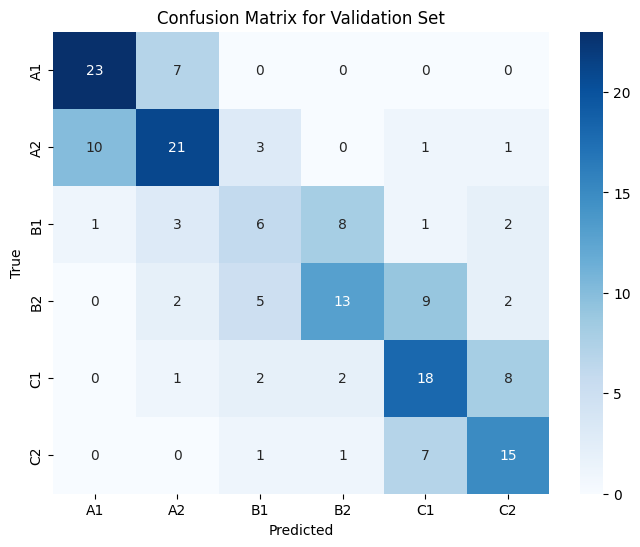

In [ ]:
#Confusion Matrix for validation set
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Set')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00        16
           2       0.22      0.77      0.34        22
           3       0.20      0.10      0.13        21
           4       0.07      0.06      0.06        17
           5       0.00      0.00      0.00        12

    accuracy                           0.20       101
   macro avg       0.08      0.15      0.09       101
weighted avg       0.10      0.20      0.11       101



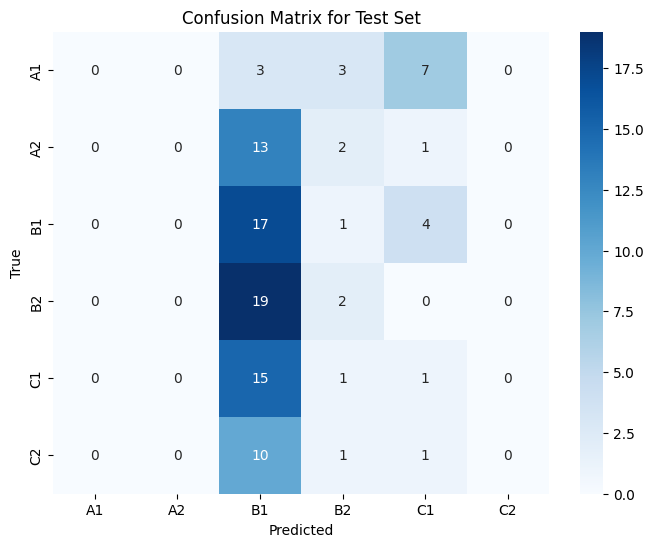

In [ ]:
#Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)
print('Classification Report:\n', class_report_test)

# Plot the confusion matrix
xticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
yticklabels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

## Notes

For this Text Classification the following observations were made:

*  Minimal Text processing improved performance (55% vs. 51% accuracy)
*  The model did not see any improvement using hyperparameter tuning
*  The model performed slightly better than chance on the validation set (55% accuracy) but performed poorly on the test data (20%) accuracy.


This poor performance is likely due to a number of reasons such as the difference in text between the train, validation and test sets and will be explored further in the final report.